### Logistic Regression (pytorch)

Made by : Yung-Kyun Noh

Department of Computer Science, Hanyang University & School of Computational Sciences, KIAS



### Overview

This notebook aims at practicing


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.distributions as distributions

#### Selection of GPU can be performed using one of the following settings:

In [2]:
# GPU selection
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
#run_gpu = 1
dev = 'cuda:0'
#dev='cpu'


#### Draw two-class data

In [4]:

def draw_state(wval, bval, data1, data2, title_str='Data'):
    # function for scattering data and drawing classification boundary
    # wx - b > 0 or  wx - b < 0

    # create a figure and axis
    fig, ax = plt.subplots()

    # Scatter data points in 2-dimensional space
    ax.scatter(data1[:,0], data1[:,1], label='class 1', c='red', alpha=.3)
    ax.scatter(data2[:,0], data2[:,1], label='class 2', marker='^', c='blue', alpha=.3)
    # set a title and labels
    ax.set_title(title_str)
    ax.legend()

    [x1min,x1max,x2min,x2max] = ax.axis()
    x1vals = np.arange(x1min,x1max,0.1)
    ax.plot(x1vals, (-wval[0]*x1vals + bval)/wval[1], 'k')
    ax.axis([x1min,x1max,x2min,x2max])
    ax.grid()


In [5]:
def logistic_function(t):
    # example: logistic_function(np.array([0,1,2]))
    ret_val = 1/(1 + torch.exp(-t))
    return ret_val

In [6]:
def get_loss(labels, fs):
    loss_val = torch.sum(-labels*torch.log(fs) - (1 - labels)*torch.log(1 - fs))
    return loss_val

### Data generation

Consider two classes of two-dimensional data, each generated from a Gaussian density function. Each class follows a Gaussian density with the same covariance matrix but different means. Since the two Gaussians share the same covariance matrix, the optimal boundary for discriminating between the two classes is linear.

For training, 50 data points are generated for each class, and for testing, 1000 data points are generated. The higher number of synthetic testing data allows for a more confident evaluation of the learned results.

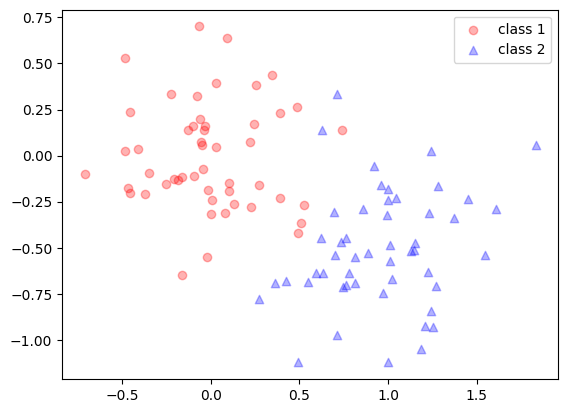

In [16]:
# generate two Gaussians (class 1 & class 2)
dim = 2
datanum1 = 50
datanum2 = 50
mean1 = np.array([0., 0.])
mean2 = np.array([1., -.5])
cov1 = np.array([[.1,.02],[.02,.1]])
cov2 = np.array([[.1,.02],[.02,.1]])
# float32
L = torch.linalg.cholesky(torch.from_numpy(cov1).to(dev)).to(torch.float32)
data1 = torch.matmul(torch.randn(datanum1, dim, device=dev, dtype=torch.float32), L.T) \
        + torch.from_numpy(mean1).to(torch.float32).to(dev)
L = torch.linalg.cholesky(torch.from_numpy(cov2).to(dev)).to(torch.float32)
data2 = torch.matmul(torch.randn(datanum2, dim, device=dev, dtype=torch.float32), L.T) \
        + torch.from_numpy(mean2).to(torch.float32).to(dev)

# data1 = np.random.multivariate_normal(mean1, cov1, datanum1)
# data2 = np.random.multivariate_normal(mean2, cov2, datanum2)

# tstdatanum1 = 1000
# tstdatanum2 = 1000
# L = torch.linalg.cholesky(torch.from_numpy(cov1).to(dev)).to(torch.float32)
# tstdata1 = torch.matmul(torch.randn(tstdatanum1, dim, device=dev, dtype=torch.float32), L.T) \
#         + torch.from_numpy(mean1).to(torch.float32).to(dev)
# L = torch.linalg.cholesky(torch.from_numpy(cov2).to(dev)).to(torch.float32)
# tstdata2 = torch.matmul(torch.randn(tstdatanum2, dim, device=dev, dtype=torch.float32), L.T) \
#         + torch.from_numpy(mean2).to(torch.float32).to(dev)

#tstdata1 = np.random.multivariate_normal(mean1, cov1, tstdatanum1)
#tstdata2 = np.random.multivariate_normal(mean2, cov2, tstdatanum2)

fig, ax = plt.subplots()

# Scatter data points in 2-dimensional space
ax.scatter(data1.cpu()[:,0], data1.cpu()[:,1], label='class 1', c='red', alpha=.3)
ax.scatter(data2.cpu()[:,0], data2.cpu()[:,1], label='class 2', marker='^', c='blue', alpha=.3)
# set a title and labels
ax.legend()

### Learning

Now we try several different levels of coding using pyTorch in order to obtain $\mathbf{w}$ and $b$ out of data. First, the subsequent update uses the gradient vector derived by taking the derivative of the objective function.



We consider the following regularized cross entropy objective:
\begin{eqnarray}
L = -\frac{1}{N}\sum_{i = 1}^N y\log f(\mathbf{x}; \mathbf{w}, b) + (1 - y)\log (1 - f(\mathbf{x}; \mathbf{w}, b))
+ \lambda(||\mathbf{w}||^2 + b^2),
\end{eqnarray}
with
\begin{eqnarray}
f(\mathbf{x}; \mathbf{w}, b) = \frac{1}{1 + \exp(\mathbf{w}^\top\mathbf{x} - b)},
\end{eqnarray}
and a small positive regularization constant $\lambda > 0$.

In [17]:
# Initialize parameters
w = torch.randn([1,dim], dtype=torch.float32, device=dev, requires_grad=True)
b = torch.randn([1,1], dtype=torch.float32, device=dev, requires_grad=True)

# extended w: [w, -b]
extw = torch.cat([w, -b], axis=1)
# data with '1' is appended: [X, 1]
extX = torch.cat((torch.cat([data1, data2], axis=0), \
                       torch.ones([datanum1 + datanum2, 1], device=dev)), axis=1)
labels = torch.cat([torch.ones(datanum1, device=dev), torch.zeros(datanum2, device=dev)])  # label of class 1: 1, label of class 2: 0


### Use the derivative of the loss function to update

The standard update of the parameters is as follows:

\begin{eqnarray}
\left(
\begin{array}{c}
\mathbf{w}_{t + 1} \\
b_{t + 1}
\end{array}
\right) =
\left(
\begin{array}{c}
\mathbf{w}_{t} \\
b_{t}
\end{array}
\right) -
\epsilon
\left(
\begin{array}{c}
\frac{dL}{d\mathbf{w}} \\
\frac{dL}{db} \\
\end{array}
\right),
\end{eqnarray}
with a small positive constant $\epsilon > 0$.

However, we can use a simpler code. We let $\mathbf{w}' = \left(\begin{array}{c}\mathbf{w} \\ -b \end{array} \right)$, the $f(\mathbf{x}; \mathbf{w}, b)$ function can be rewritten using $\mathbf{w}'$ as
\begin{eqnarray}
f(\mathbf{x}; \mathbf{w}') = f(\mathbf{x}; \mathbf{w}, b) = \frac{1}{1 + \exp(\mathbf{w}^\top\mathbf{x} - b)}
= \frac{1}{1 + \exp\left(\mathbf{w}'^\top\left(\begin{array}{c}\mathbf{x} \\ 1 \end{array}\right)\right)},
\end{eqnarray}

We can derive $\frac{dL}{d\mathbf{w}'}$ and make a new update rule.
\begin{eqnarray}
\mathbf{w}'_{t + 1} = \mathbf{w}_t - \epsilon \frac{dL}{d\mathbf{w}'},
\end{eqnarray}
with a small positive $\epsilon > 0$.

In [18]:
def update_w_vanilla(extw, extX, labels, num_update=100, step_size=0.001, reg_const=1):
    draw_state(extw[0,0:2].cpu().detach().numpy(), -extw[0,2].cpu().detach().numpy(), data1.cpu(), data2.cpu(), 'Before update')

    objective_history = []
    for i in range(num_update):
        ts = torch.matmul(extX, extw.T).T  # w^TX
        fs = logistic_function(ts)
        extw = extw + step_size*(torch.matmul(labels - fs, extX) - reg_const*extw)
        objective_history.append(float(get_loss(labels, fs[0]).cpu().detach().numpy()))

    draw_state(extw[0,0:2].cpu().detach().numpy(), -extw[0,2].cpu().detach().numpy(), data1.cpu(), data2.cpu(), 'Updated boundary')

    fig, ax = plt.subplots()
    ax.plot(objective_history)
    ax.set_title("objective function")

    return extw


Now we implemented our manual update code with the derivatives $\frac{dL}{d\mathbf{w}}$ and $\frac{dL}{db}$ that have been devied by us.

The update of the parameters show the update of the boundary. The boundary is determined by $\mathbf{w}$ and $b$.

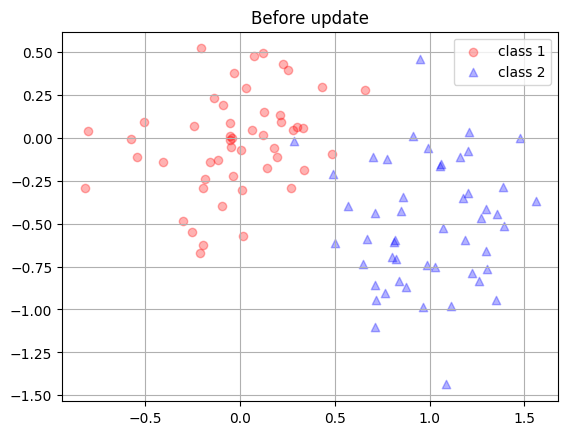

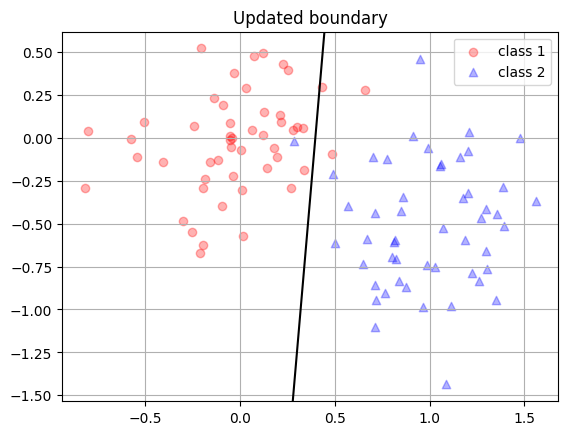

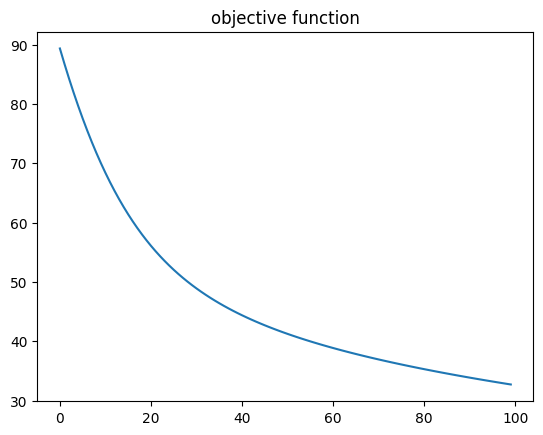

In [ ]:
extw = update_w_vanilla(extw, extX, labels, num_update=100, step_size=0.001, reg_const=0)

Further update show improved results, and the objective function value keep decreases.

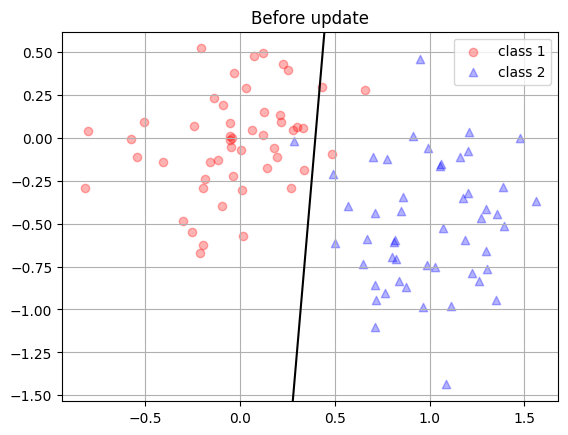

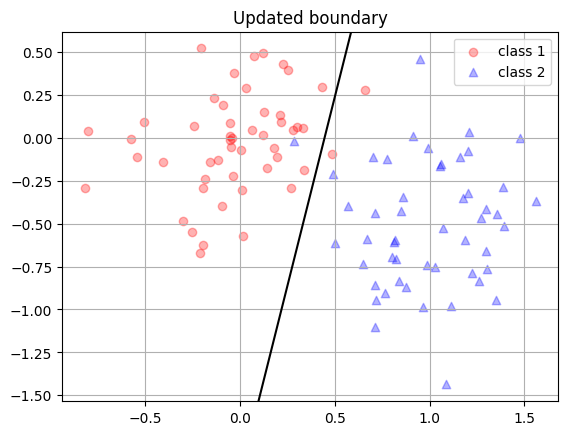

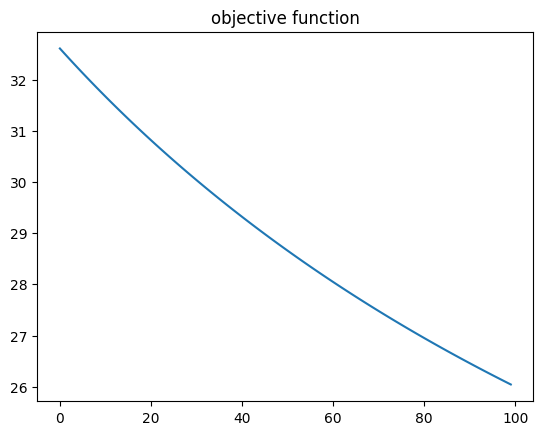

In [ ]:
# Additional 100 updates
extw = update_w_vanilla(extw, extX, labels)

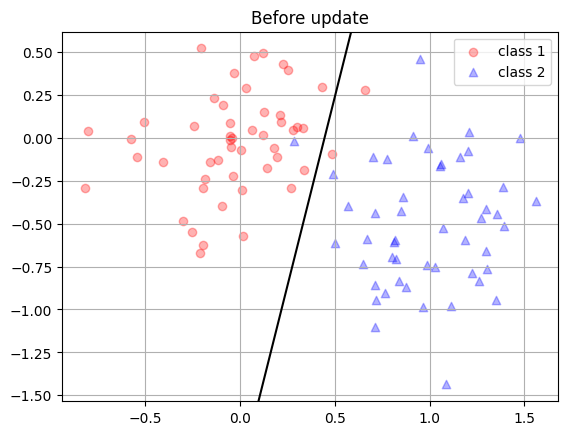

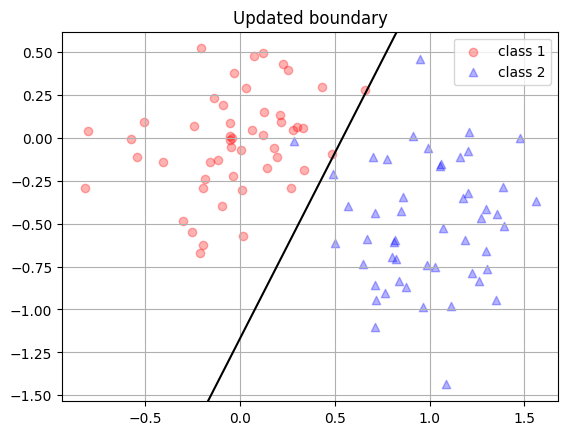

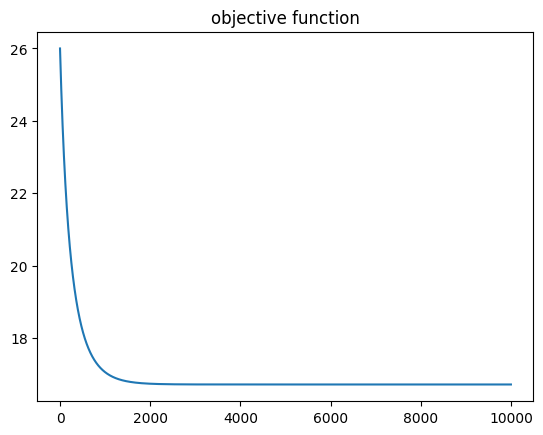

In [ ]:
# After enough updates
extw = update_w_vanilla(extw, extX, labels, num_update=10000)

### Evaluation

Now we use the testing data to estimate the expected error for untrained data. The error is approximated $3\%$.

In [ ]:
# data with '1' is appended: [X, 1]
extTstX = torch.cat([torch.cat([tstdata1, tstdata2], axis=0), \
                       torch.ones([tstdatanum1 + tstdatanum2, 1], device=dev)], axis=1)
labels = torch.cat([torch.ones(tstdatanum1, device=dev), torch.zeros(tstdatanum2, device=dev)])

ts = torch.matmul(extTstX, extw.T)  # w^TX
err_rate = torch.sum(torch.abs((ts.T > 0)*1. - labels))/(tstdatanum1 + tstdatanum2)
print(err_rate)

tensor(0.0280, device='cuda:0')


### Use torch optimization

We implemented the gradient descent algorithm using python code. Now we borrow some pre-implemented codes from pyTorch and see how the update in the previous example can be performed using basic optimization functions in pyTorch.

The following code performs one step of the update using the predefined information in optimizer.

```python
        cost = model.get_loss(data, labels)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
```

We first make a sample class that keeps the parameters of prediction function $f(\mathbf{x}; \mathbf{w}, b)$ in the above example. Forward function implements the calculation of the function $f(\mathbf{x}; \mathbf{w}, b)$ with input $\mathbf{x}$.

In [ ]:
# For test 1
class LogisticRegression_torch_0(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression_torch_0, self).__init__()
        self.w = torch.randn([1,dim], dtype=torch.float32, device=dev, requires_grad=True)
        self.b = torch.randn([1,1], dtype=torch.float32, device=dev, requires_grad=True)
    def forward(self, x):
        outputs = torch.sigmoid(torch.matmul(self.w, x.T) - self.b)
        return outputs



When we initialize the class, the parameters $\mathbf{w}$ and $b$ are also initialized with random floats. The update parameters should have the option "requres_grad=True."

In our test of pyTorch optimization functions, we use the two-norm of $\mathbf{w}$ ($=||\mathrm{w}||^2$) as our cost. Let's observe how the pyTorch optimization functions decrease the cost after a single step is taken.  

In [ ]:
# Test 1
model = LogisticRegression_torch_0(input_dim=dim, output_dim=1).to(dev)

cost = torch.sum(model.w**2)
print("Cost before taking a single optimization step:", cost.item())
print('w:', model.w.cpu().detach().numpy())

optimizer = torch.optim.SGD([model.w, model.b], lr=0.01)
optimizer.zero_grad()
cost.backward()
optimizer.step()

cost = torch.sum(model.w**2)
print("Cost after taking a single optimization step:", cost.item())
print('w:', model.w.cpu().detach().numpy())


Cost before taking a single optimization step: 2.6665844917297363
w: [[-0.95229805  1.3265417 ]]
Cost after taking a single optimization step: 2.5609874725341797
w: [[-0.9332521  1.3000108]]


We now construct a class with an implementation of the objective function:

```python
 get_loss(self, data, labels)
```

The loss is the cross entropy loss.

In [ ]:
# For test 1
class LogisticRegression_torch1(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression_torch1, self).__init__()
        self.w = torch.randn([1,dim], dtype=torch.float32, device=dev, requires_grad=True)
        self.b = torch.randn([1,1], dtype=torch.float32, device=dev, requires_grad=True)
    def get_loss(self, data, labels):
        fs = self.forward(data)
        loss_val = torch.sum(-labels*torch.log(fs) - (1 - labels)*torch.log(1 - fs))
        return loss_val
    def forward(self, x):
        outputs = torch.sigmoid(torch.matmul(self.w, x.T) - self.b)
        return outputs


A series of updates is performed in the for loop:

In [ ]:
def update_w_torch1(model, data, labels, num_update=100, step_size=0.001):
    draw_state(model.w[0].cpu().detach().numpy(), model.b[0].cpu().detach().numpy(), data1.cpu(), data2.cpu(), 'Before update')

    optimizer = torch.optim.SGD([model.w, model.b], lr=step_size)
    objective_history = []

    for i in range(num_update):
        cost = model.get_loss(data, labels)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        objective_history.append(float(cost))
#     print(objective_history)

    draw_state(model.w[0].cpu().detach().numpy(), model.b[0].cpu().detach().numpy(), data1.cpu(), data2.cpu(), 'Updated boundary')

    fig, ax = plt.subplots()
    ax.plot(objective_history)
    ax.set_title("objective function")


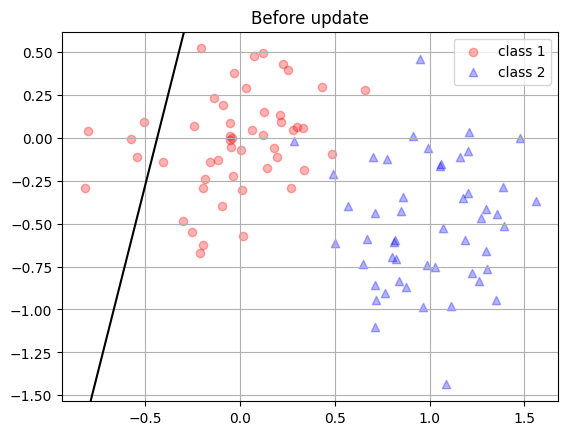

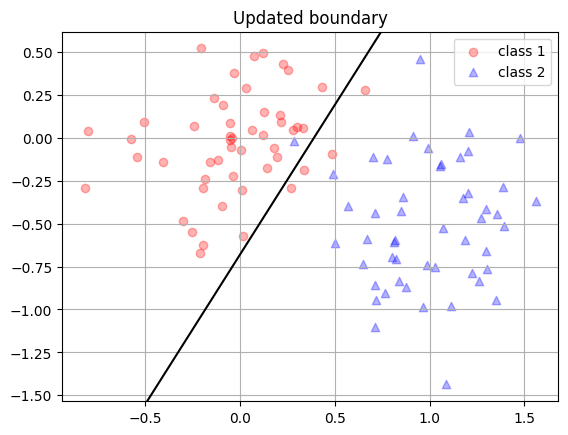

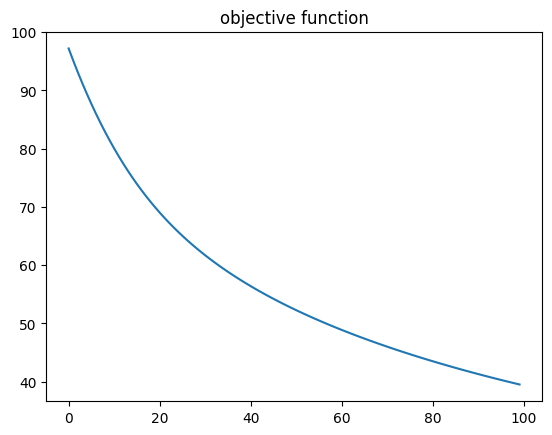

In [ ]:
# data with '1' is appended: [X, 1]
data = torch.cat([data1, data2], axis=0)
labels = torch.cat([torch.ones(datanum1, device=dev), torch.zeros(datanum2, device=dev)])  # label of class 1: 1, label of class 2: 0

model = LogisticRegression_torch1(input_dim=dim, output_dim=1).to(dev)
update_w_torch1(model, data, labels, num_update=100, step_size=0.001)

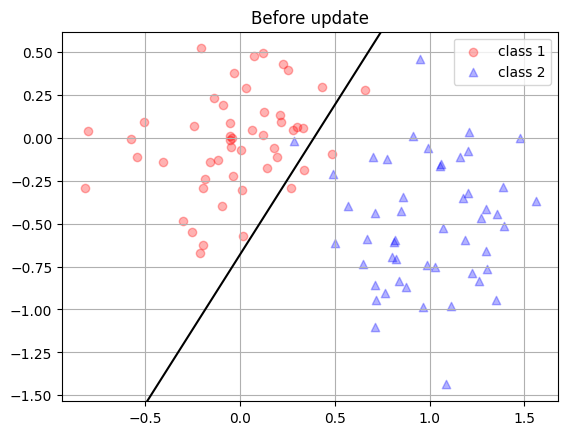

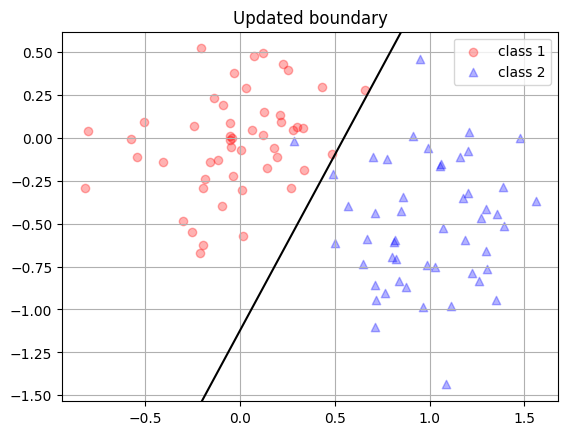

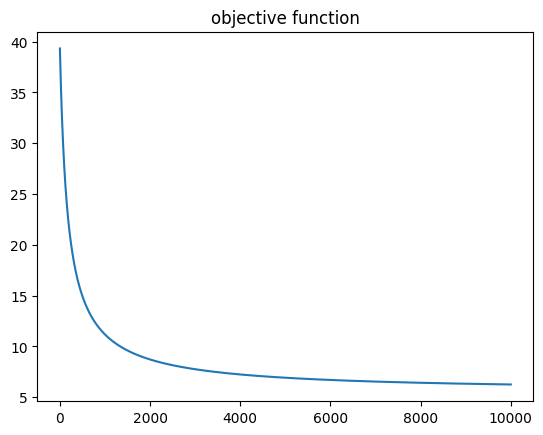

In [ ]:
update_w_torch1(model, data, labels, num_update=10000, step_size=0.001)